# Task
One of the hurdles of investing in cryptocurrencies is the high volatility of the asset class. There have been some research efforts done to model the volatility behaviour of the biggest asset - Bitcoin.

We would like you to review the current research results, comment on them, and propose a model that would be suitable for us to incorporate into our asset allocation model? If you have a better model than the researched ones, feel free to propose your recommendation (and code) as well. 

-----

# Introduction
With the popularity of new asset class - cryptocurrencies growing in recent years, there is no reason to not include them as diversifiers for asset allocations. In this task, we focus on the most popular cryptocurrency - Bitcoin. Bitcoin is highly volatile. The estimation of Bitcoin's realised volatitility suggest it is around 3x as volatite as equity. From an asset allocation point's of view, being able to accurately forecast its volatility is absolute essential for hitting the volatility targets of a portfolio. 

In this task, we reviewed some papers, implemented some models in Python and commented on their suitability for Bitcoin's volatility forecasting.


# Papers review
The most popular choice of Bitcoin's volatility forecasting models are GARCH and Stochastic Volatility models, based on internet search results. In this document, we reviewed the following two papers:
1. Kim, J.-M.; Jun, C.; Lee, J.
Forecasting the Volatility of the
Cryptocurrency Market by GARCH
and Stochastic Volatility. Mathematics
2021, 9, 1614. https://doi.org/10.3390/math9141614
    - This paper investigated the volatility forecasting performance of Stochastic Volatility (SV) model and several GARCH models on top 9 mostly traded cryptocurrencies. It concluded SV model performs better than GARCH models, especially when the forecast horizon increases.

1. Zahid, Mamoona and Iqbal, Farhat (2020) Modeling the volatility of cryptocurrencies: an empirical application of stochastic volatility models. Sains Malaysiana, 49 (3). pp. 703-712. ISSN 0126-6039. http://www.ukm.edu.my/jsm/pdf_files/SM-PDF-49-3-2020/ARTIKEL%2025.pdf
    - This paper investigated a number of stochastic volatility (SV) models for forecasting the volatility of the top 4 most capitalised cryptocurrencies. The main finding is the heavy-tailed SV model performs better than other competing models (SV, SV-t, SV-MA).



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# example of ARCH model
from arch import arch_model

import pymc3 as pm # stochastic volatility model
import arviz as az

## Investigate Bitcoin's volatility statistical properties
Before we start the implementation, we check for volatility clustering and time-varying property of Bitcoin.

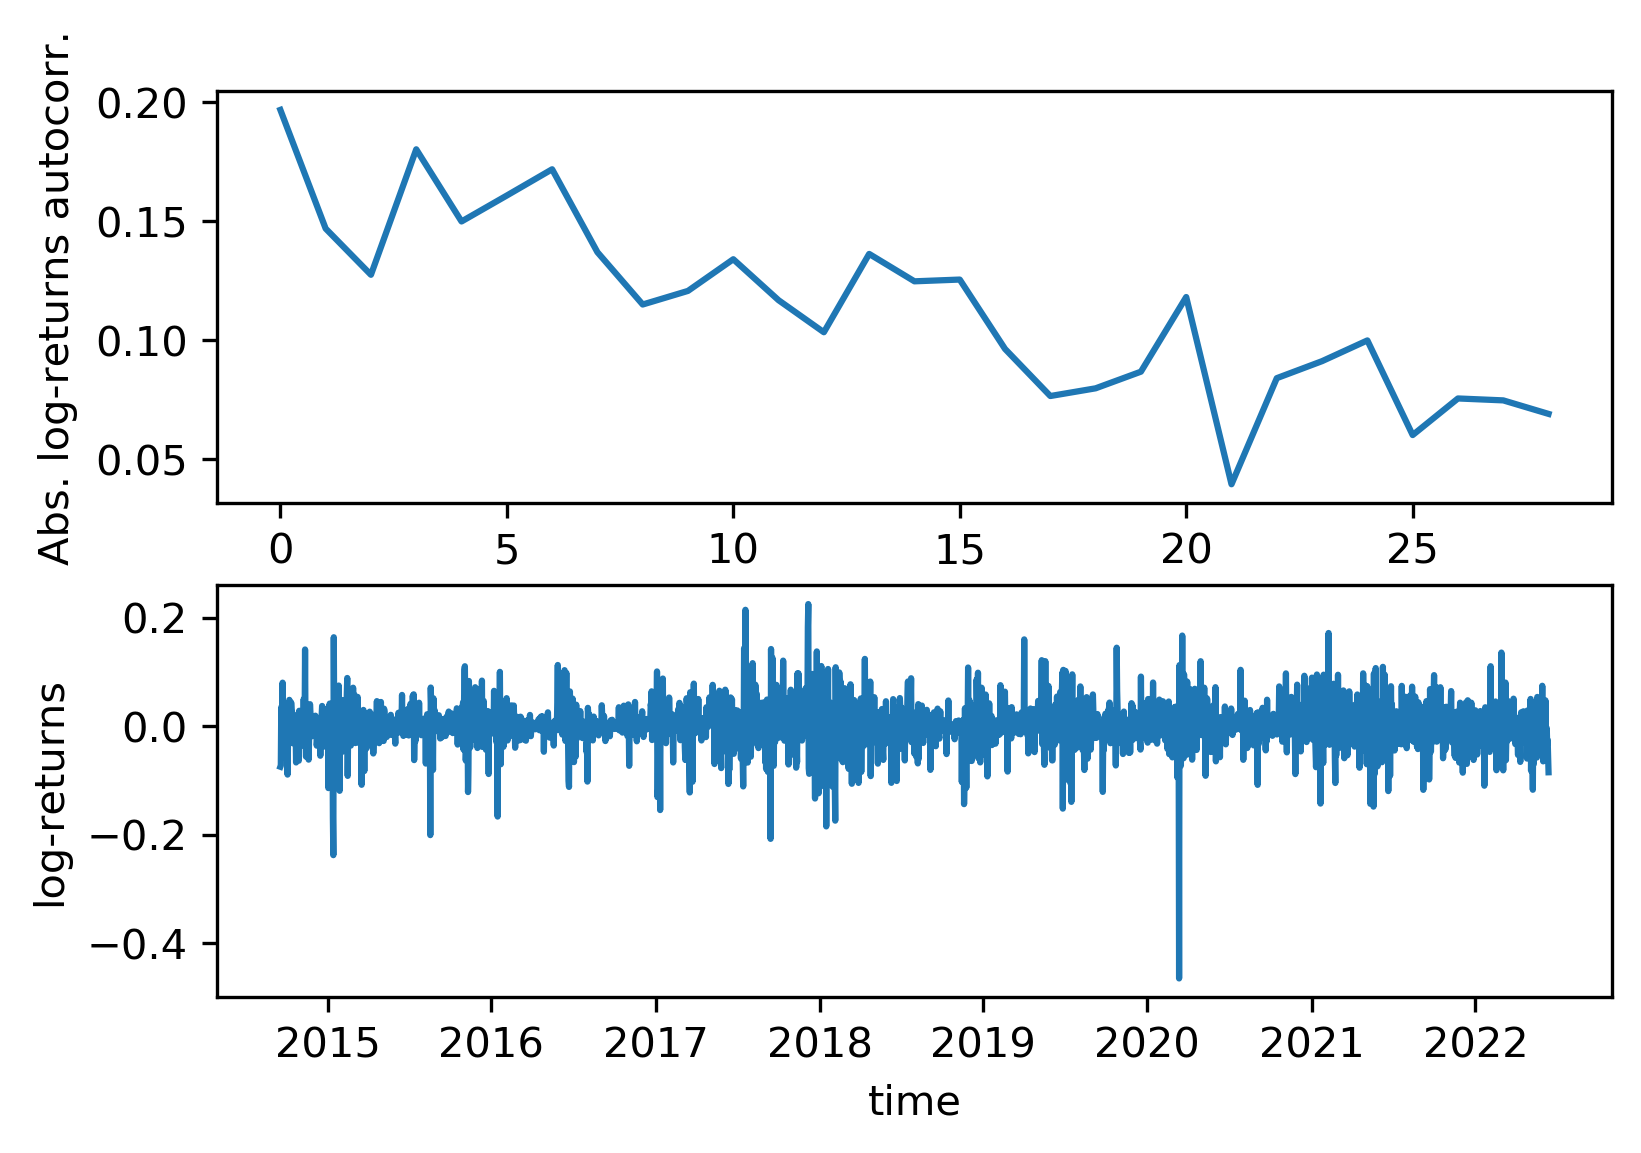

In [2]:
df = pd.read_csv("/home/chunkiat/Desktop/Stashaway/BTC-USD.csv") # from yahoo finance
df["Date"] = pd.to_datetime(df["Date"])
df = df[["Date", "Close"]]
df.columns = ["date", "spot"]
df = df.resample('D', on='date').last().reset_index(drop = True)
df["log_ret"] = np.log(df["spot"]/df["spot"].shift(1))
df = df[df["log_ret"].notna()].reset_index(drop = True)

# Check for volatility clustering
df["abs_log_ret"] = abs(df["log_ret"])
auto_corr = []
for lags in range(1,30):
    auto_corr.append(np.corrcoef(df["abs_log_ret"][lags:], df["abs_log_ret"].shift(lags)[lags:])[0,1])

fig,ax = plt.subplots(2,1,dpi = 300)
ax[0].plot(auto_corr)
ax[0].set_xlabel("Lags")
ax[0].set_ylabel("Abs. log-returns autocorr.")

ax[1].plot(df["date"], df["log_ret"])
ax[1].set(xlabel="time", ylabel="log-returns")

plt.show()


# fig,ax = plt.subplots(1,1,dpi = 200)
# ax.plot(df["date"], df["spot"])
# ax.set_ylabel("USD")
# ax.set_xlabel("Time")
# plt.show()

In the first plot, we can see autocorrelation of absolute log-returns decreases as lag increases. This shows the existence of volatility clustering. The second plot shows the observation of time-varying volatility. This leads to the  choice of GARCH, Stochastic Volatility (SV) and HAR models for volatility forecasting. 

# Model Implementations 
Here we implement some basic version of HAR, GARCH and SV models, and evaluate their performance based on mean squared error (MSE).
\begin{align*}
\text{MSE} = \frac{1}{N}\sum^N_{i=1} (\text{actual variance} - \text{predicted variance})^2
\end{align*}


## GARCH model

In [3]:
# Fit GARCH(1,1) model & do a recursive 1-step ahead forecast 
# (i.e. expand the observation sample after each 1-step forecast)
am = arch_model(df["log_ret"], vol="Garch", p=1, o=0, q=1, dist="Normal", rescale = True)

n_test = int(0.2*len(df))
train, test = df["log_ret"][:-n_test], df["log_ret"][-n_test:]

end_loc = len(train)
forecasts = {}
for i in range(1,n_test+1):
    res = am.fit(last_obs = i + end_loc, disp="off")
    scale = res.scale
    temp = res.forecast(horizon=1, reindex=False).variance
    fcast = temp.iloc[0]
    # Rescale the variance
    forecasts[fcast.name] = fcast/scale**2
    
predicted_variance = np.array(pd.DataFrame(forecasts).T["h.1"])
actual_variance = np.array(test**2)

# Compute MSE
mse = np.mean((predicted_variance - actual_variance)**2)
print("MSE = ", mse)


MSE =  6.976031040888713e-06


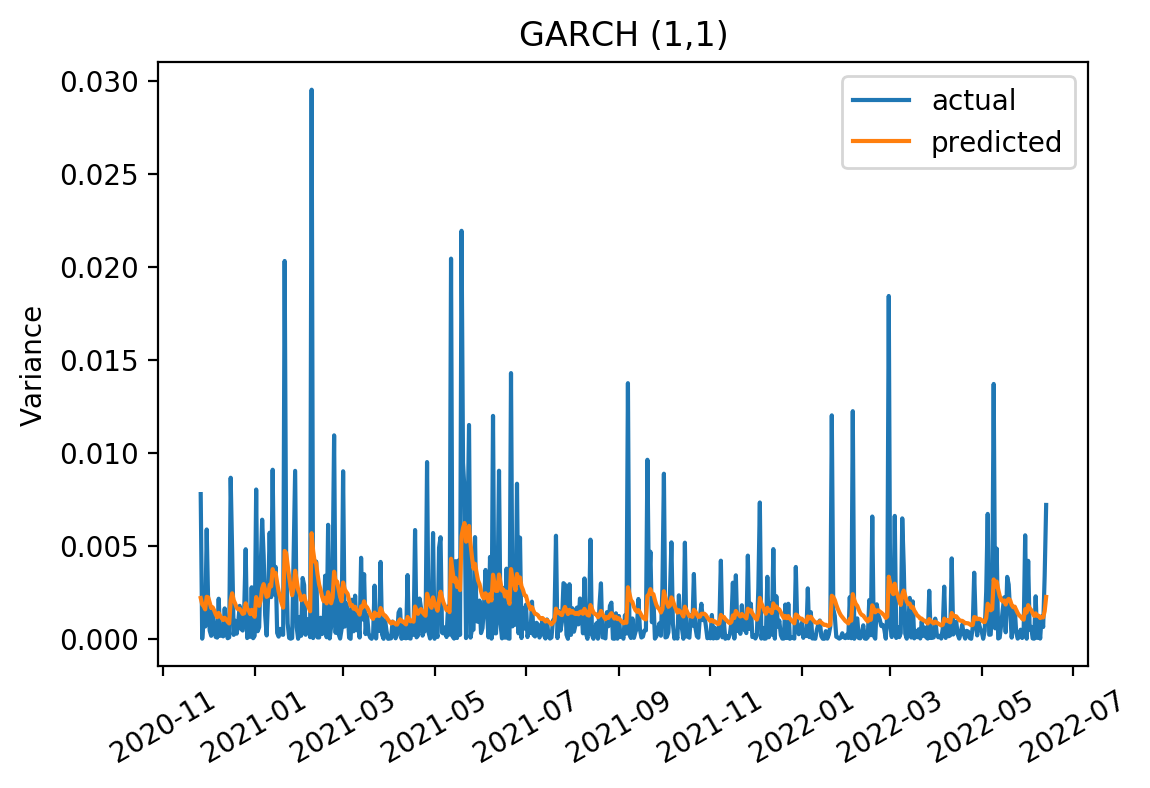

In [4]:
fig, ax = plt.subplots(1,1, dpi =200)
ax.plot(df.loc[test.index,:]['date'], actual_variance, label = "actual")
ax.plot(df.loc[test.index,:]['date'], predicted_variance, label = "predicted")
ax.set_title("GARCH (1,1)")
ax.set_ylabel("Variance")
ax.set_title("GARCH (1,1)")
ax.tick_params(axis='x', labelrotation = 30)
ax.legend()
plt.show()

## Stochastic Volatility model

In [5]:
returns = df[["date", "log_ret"]]
returns = returns.set_index("date")

with pm.Model() as BTC_model:
    btc_returns = pm.Data("returns", returns["log_ret"], dims = "date", export_index_as_coords = True)
    
    nu = pm.Exponential("nu", 0.1, testval = 5.0)
    
    sigma = pm.Exponential("sigma", 50, testval = 0.1)
    
    s = pm.GaussianRandomWalk("s", sigma = sigma, dims = "date")
    
    vol_process = pm.Deterministic("volatility_process", pm.math.exp(-2*s)**0.5, dims = "date")
    
    r = pm.StudentT("r", nu = nu, sigma = vol_process, observed = btc_returns, dims = "date")

In [6]:
with BTC_model:
    trace = pm.sample(2000, init = "adapt_diag", return_inferencedata = False)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [s, sigma, nu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 213 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [7]:
predicted_variance = np.mean((1/np.exp(trace["s", ::5].T)),axis  = 1)[-n_test:]**2
actual_variance = np.array(test**2)

# Compute MSE
mse = np.mean((predicted_variance - actual_variance)**2)
print("MSE = ", mse)


MSE =  8.966949666933044e-06


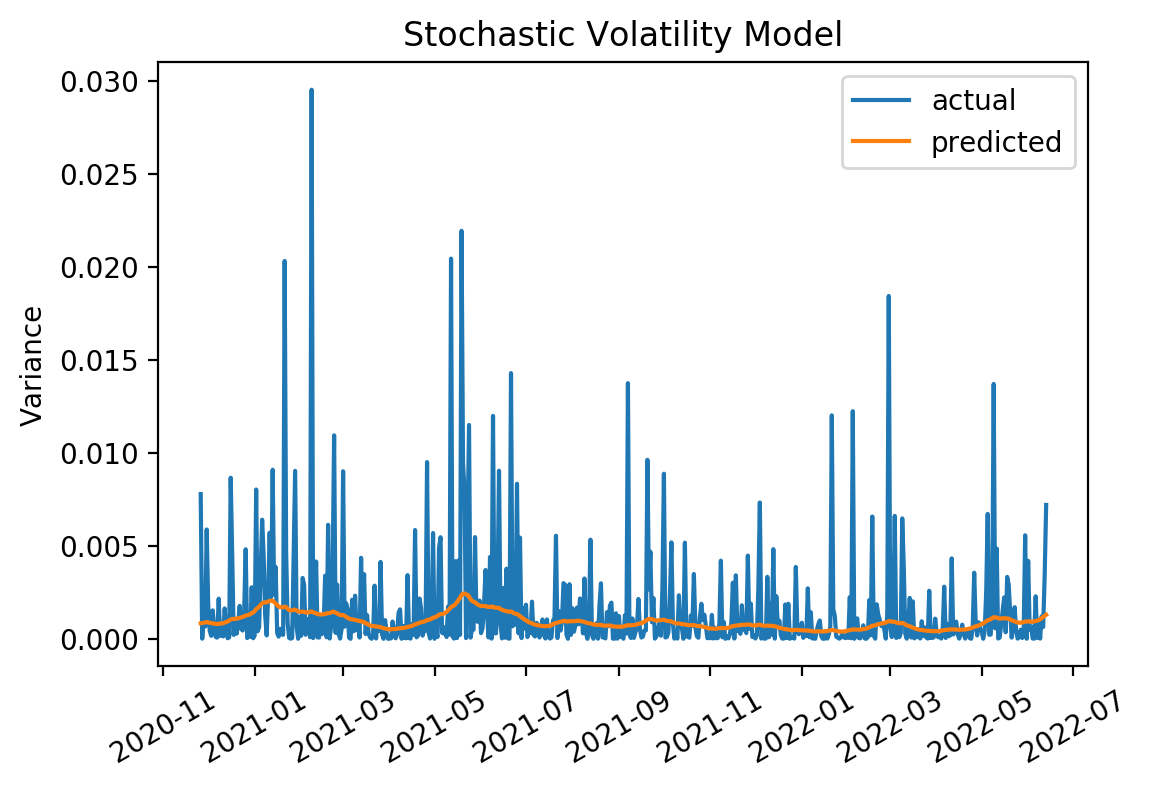

In [8]:
fig, ax = plt.subplots(1,1, dpi =200)
ax.plot(df.loc[test.index,:]['date'], actual_variance, label = "actual")
ax.plot(df.loc[test.index,:]['date'], predicted_variance, label = "predicted")
ax.set_title("Stochastic Volatility Model")
ax.set_ylabel("Variance")
ax.tick_params(axis='x', labelrotation = 30)
ax.legend()
plt.show()

# Conclusion
We observed that GARCH model gives a smaller MSE value than SV model does in our experiment. This result contradicts with that suggested by the literature. We think it is because of different distribution parameters used in the SV model. With the results we currently have, GARCH model is **proposed** as the method to forecast Bitcoin's volatility. 

## Future outlook
However, there are a few improvements / models that we intended to examine but failed to do so due to time constraints:
1. SV model's distribution parameters calibration
1. HAR model - This is also a popular choice of model for cryptocurrency volatility forecasting
1. Rough volatility model - This idea was first introduced in 2016 by Jim Gatheral et al. for option pricing. It was observed that the log-volatility process of high frequency data behaves essentially as a fractional Brownian motion with Hurst exponent H < 0.5. For our application, typically low frequency data (decided by rebalancing frequency) is used. One needs to check if the log-volatility process of low frequency data exhibits the same characteristics. 

# References
1. Stochastic Volatility model implementation: https://docs.pymc.io/en/v3/pymc-examples/examples/case_studies/stochastic_volatility.html
1. GARCH model implementation: https://arch.readthedocs.io/en/latest/univariate/univariate_volatility_forecasting.html
1. Rough volatility: https://www.tandfonline.com/doi/full/10.1080/14697688.2017.1393551